## Document Extraction Example: Bullet Points (no formulas or tables)
Goal: Convert paragraphs and bullet points from pdf document into table of conditions and definitions. Typical set of terms will look like the following: 
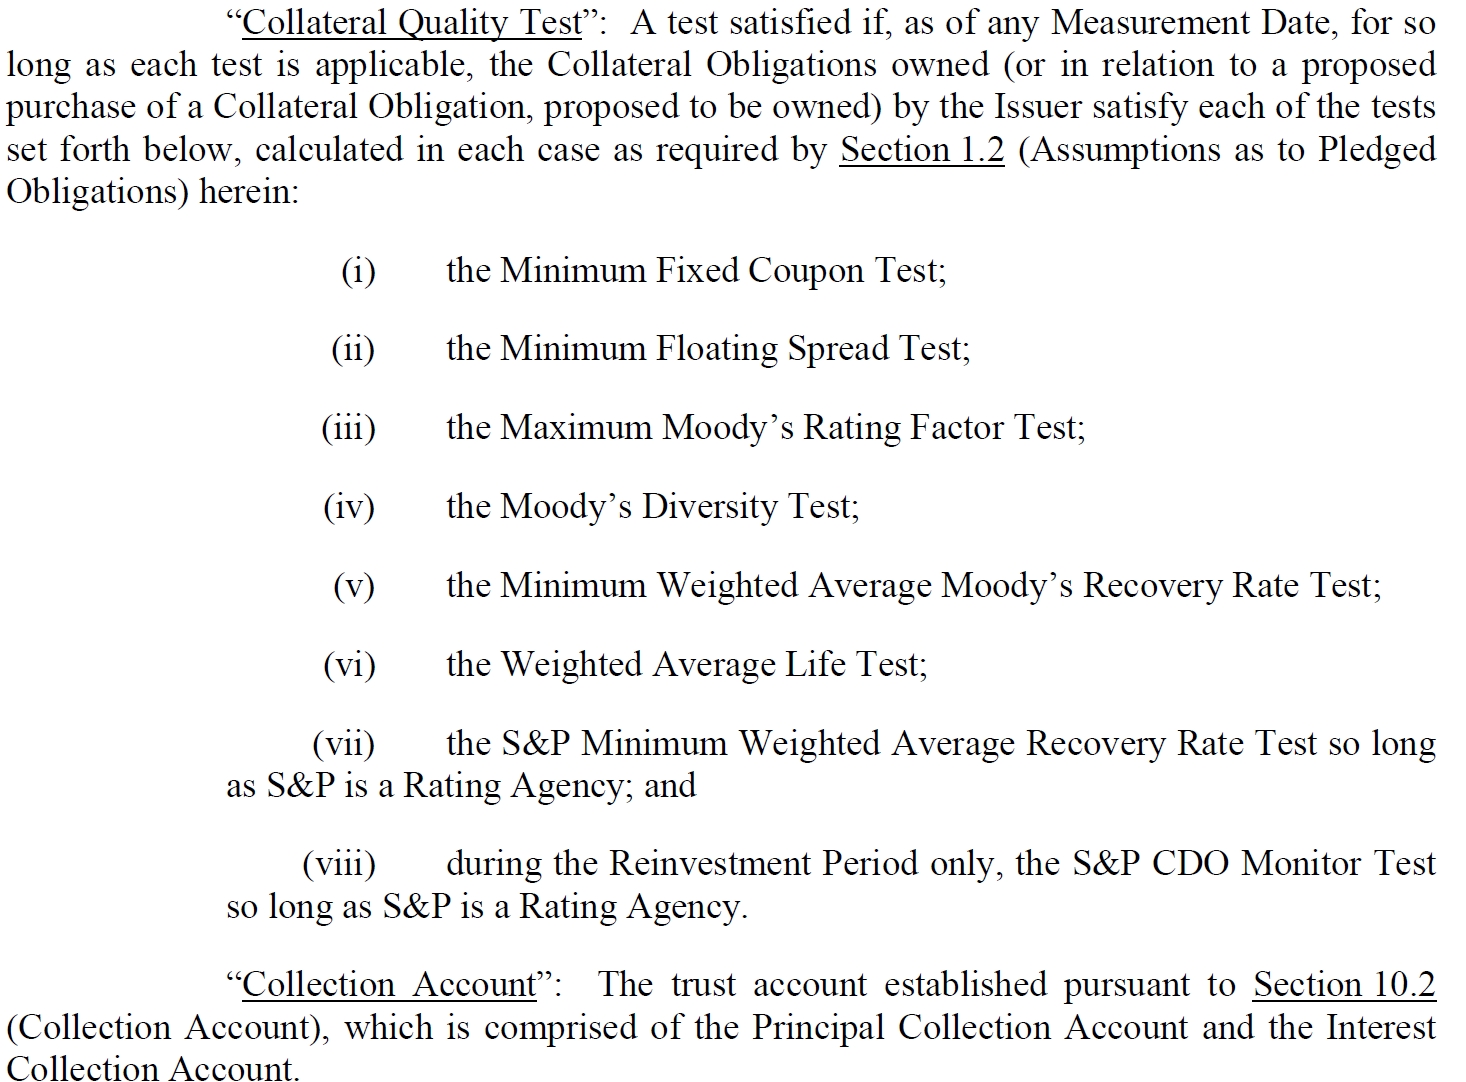
Definitions currently in multiple forms: <br>
- Bullet Points with only text. These can be displayed as is. 
- Verbal formulas: "greater than, equal, etc.": these need to be translated to ">, =, etc."
- Tables <br> 

We will start with the first type and convert the bullet points into a table for our sample file. 

In [1]:
# library import
import os
import re
import pdfplumber
import numpy as np
import pandas as pd 
import json

import scrape   # custom file

In [2]:
# Enable multiple output per cell. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Extract Pages
Goal is create table with sample sections for **Collateral Quality Test**. Extract relevant pages from pdf then combine into one string.

In [3]:
# Specify document and page numbers to extract 
file_name = 'OHA XII Indenture.pdf'
start_page = 22
end_page = 35 

In [4]:
page_list = scrape.pdf_extract_pages(file_name, start_page, end_page)  # Extract pages
doc_str = scrape.combine_strings(page_list)   # combine pages into one string

In [5]:
end_doc = len(doc_str)

### Define start and end of search section based on **search_string**
1.  Use "Collateral Quality Test"
2.  Use **“** as marker for next section 

In [6]:
search_string = '“Collateral Quality Test”'
match = re.search(search_string, doc_str)  
start_collat = match.span()[0]            # start location of search string 
end_collat = match.span()[1]              # end location of search string 
print("start of search_string is :", start_collat) 
doc_str[start_collat:end_collat]

start of search_string is : 835


'“Collateral Quality Test”'

In [7]:
# find next open quotation: “ 
first_word_len = len(search_string)
doc_sub = doc_str[(start_collat+1):end_doc]   #substring of section to end of doc
next_loc = doc_sub.find('“')
doc_sub[next_loc:next_loc+11]
start_next = start_collat + next_loc + 1 
start_next

'“Collection'

1705

### Use regex to isolate bullet points and store values in table. 
1. Isolate substring for Collateral Quality 
2. Use **regex** (regular expressions) to grab roman numerals **locations**. 

In [8]:
sub_doc_str = doc_str[start_collat:start_next]
# sub_doc_str2 = sub_doc_str.replace('\n','') # same string with newlines removed

In [9]:
regex = r"\([vix]+\)"
# regex = r"\([vix]+\)((.*\n.*) | .*)[;\.]"
bullet_ranges = scrape.text_match_2list(regex, sub_doc_str)  # grab locations for roman numerals
[doc_sub[x[0]-1:x[1]] for x in bullet_ranges]  # print string output. match returns location after match so must subtract one. 

(400, 403)
(437, 441)
(478, 483)
(526, 530)
(561, 564)
(624, 628)
(663, 668)
(763, 769)


['(i) ', '(ii) ', '(iii) ', '(iv) ', '(v) ', '(vi) ', '(vii) ', '(viii) ']

### Grab Bullet Points and Store in Dictionary
1. Append all conditions (*except last*) for Collateral Quality through loop by isolating text between roman numerals. Then clean up each bullet item. 
2. Creat dictionary with defined value ("Collateral Quality") as key, and condition list as values. 
3. Convert dictionary to table (through dataframe). 

In [10]:
# Grab text between list of locations. in this case, the bullet items between roman numeral locations
collat_qual_def = scrape.list_betweenloc_to_string_bounded(bullet_ranges, sub_doc_str, start_next)
# remove extraneous items like leading whitespace, new lines, etc. 
collat_qual_def = scrape.str_item_cleanup(collat_qual_def)
collat_qual_def

['the Minimum Fixed Coupon Test ',
 'the Minimum Floating Spread Test ',
 'the Maximum Moody’s Rating Factor Test ',
 'the Moody’s Diversity Test ',
 'the Minimum Weighted Average Moody’s Recovery Rate Test ',
 'the Weighted Average Life Test ',
 'the S&P Minimum Weighted Average Recovery Rate Test so long as S&P is a Rating Agency and ',
 'during the Reinvestment Period only, the S&P CDO Monitor Test so long as S&P is a Rating Agency. ']

In [11]:
# Store Collateral Quality and conditions in dictionary
conditions_dict = {}
conditions_dict['Collateral Quality Test'] = collat_qual_def
df = pd.DataFrame(data=conditions_dict)
df

,Collateral Quality Test
0,the Minimum Fixed Coupon Test
1,the Minimum Floating Spread Test
2,the Maximum Moody’s Rating Factor Test
3,the Moody’s Diversity Test
4,the Minimum Weighted Average Moody’s Recovery ...
5,the Weighted Average Life Test
6,the S&P Minimum Weighted Average Recovery Rate...
7,"during the Reinvestment Period only, the S&P C..."


### Definition Lists
Grab full list of definition names from two files

In [3]:
file_name_vib = 'Vibrant VIII - Indenture(133849278_1).pdf'
start_page_vib = 8
end_page_vib = 74

file_name_oh = 'OHA XII Indenture.pdf'
start_page_oh = 8
end_page_oh = 85

In [4]:
# extract pages from both documents
oh_pages = scrape.pdf_extract_pages(file_name_oh, start_page_oh, end_page_oh)
doc_str_oh = scrape.combine_strings(oh_pages) 
vib_pages = scrape.pdf_extract_pages(file_name_vib, start_page_vib, end_page_vib)
doc_str_vib = scrape.combine_strings(vib_pages)

In [8]:
# isolate ranges for both files
regex_oh = r'“.*”:'
regex_vib = r'".*":'
name_range_oh = scrape.text_match_str2list(regex_oh, doc_str_oh)
name_range_vib = scrape.text_match_str2list(regex_vib, doc_str_vib)

Store of list of definition names into dictionary, then export through dataframe

In [11]:
# filter out beginning and end quote/colon from each line 
name_range_oh = [x[1:(len(x)-2)] for x in name_range_oh]
name_range_vib = [x[1:(len(x)-2)] for x in name_range_vib]

In [13]:
doc_def_dict={}
doc_def_dict['OH'] = name_range_oh
doc_def_dict['Vib'] = name_range_vib

In [17]:
df1 = pd.DataFrame(data=doc_def_dict['OH'])
df1.columns = ['OH']
df2 = pd.DataFrame(data=doc_def_dict['Vib'])
df2.columns = ['Vib']
df = pd.concat([df1, df2], axis=1)
df.head() 

,OH,Vib
0,Acceleration Event,17g-5 Information Provider
1,Acceleration Priority of Payments,17g-5 Information Provider's Website
2,Account Agreement,Acceleration Event
3,Accountants’ Effective Date Comparison AUP Report,Accountants' Report
4,Accountants’ Effective Date Recalculation AUP ...,Accounts
